<a href="https://colab.research.google.com/github/nikolmash/compling-it2020/blob/master/hw3_compling%26it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных



Скачиваем и извлекаем из архива данные:

In [1]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-10-18 18:41:37--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  18.5MB/s    in 9.3s    

2020-10-18 18:41:47 (8.61 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
!tar -xf aclImdb_v1.tar.gz

Запишем текст в удобный формат pandas. Сразу извлекаем значения классов (1 и 0)

In [3]:
import os
import pandas as pd
import numpy as np
 
train_texts, test_texts = [],[]
train_labels, test_labels = [],[]

for file in os.listdir('aclImdb/train/pos'):
  with open(os.path.join('aclImdb/train/pos', file)) as f:
    t = f.read()
    train_texts.append(t)
    train_labels.append(1)
for file in os.listdir('aclImdb/train/neg'):
  with open(os.path.join('aclImdb/train/neg', file)) as f:
    t = f.read()
    train_texts.append(t)
    train_labels.append(0)

for file in os.listdir('aclImdb/test/pos'):
  with open(os.path.join('aclImdb/test/pos', file)) as f:
    t = f.read()
    test_texts.append(t)
    test_labels.append(1)
for file in os.listdir('aclImdb/test/neg'):
  with open(os.path.join('aclImdb/test/neg', file)) as f:
    t = f.read()
    test_texts.append(t)
    test_labels.append(0)

In [4]:
train = pd.DataFrame({'text': train_texts, 'label': train_labels})
test = pd.DataFrame({'text': test_texts, 'label': test_labels})

In [5]:
train.head()

,text,label
0,Gundam Wing is a fun show. I appreciate it for...,1
1,This movie is horrible- in a 'so bad it's good...,1
2,I feel very sorry for people who go to movies ...,1
3,Recap: Zandalee is a young woman that feels mo...,1
4,Monstervision was a show I grew up with. From ...,1


In [6]:
test.head()

,text,label
0,The Commenter before me stated this movie is t...,1
1,Not a box office success; no-one really knows ...,1
2,"I'm not sure what version of the film I saw, b...",1
3,It Came from Outer Space II is a very good fil...,1
4,If you like the excitement of a good submarine...,1


# Предобработка


In [13]:
import re
import nltk
import spacy
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

Загружаем и создаем необходимые для предобработки сущности:

In [8]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = stopwords.words('english')
punkt = punctuation + '«»—…“”*№–'
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Напишем функцию препроцессинга, где:

- параметр lemmatizing отвечает за наличие или отсутствие лемматизации
- удаляются имейлы, html-теги и url, если они есть
- происходит токенизация
- удаляются знаки препинания
- удаляются стоп-слова
- все приводится к нижнему регистру

In [9]:
def preprocessing(text, lemmatizing) -> str:
  url_pattern = re.compile(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*')
  email_pattern = re.compile(r'[\w.-]+@[\w.-]+.\w+')
  html_pattern = re.compile(r'<.*?>')
  for pattern in (url_pattern, email_pattern, html_pattern):
    text = pattern.sub('', text)
  doc = nlp(text)
  #токенизируем, убираем стоп-слова и пунктуацию
  tokens = [token.text.lower() for token in doc if token.text.lower() not in stopwords and token.text.lower() not in punkt]
  if lemmatizing == True:
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]
    clean_text = ' '.join([word for word in lemmas if re.match(r'\W+', word) is None])
  else:
    clean_text = ' '.join([word for word in tokens if re.match(r'\W+', word) is None])
  return clean_text

Я отдельно сохраню лемматизированные и нелемматизированные обработанные тексты. Заодно проверим, как это влияет на качество классификации

In [10]:
train_lemmatized = train['text'].apply(lambda x: preprocessing(x, True))
train_preprocessed = train['text'].apply(lambda x: preprocessing(x, False))
test_lemmatized = test['text'].apply(lambda x: preprocessing(x, True))
test_preprocessed = test['text'].apply(lambda x: preprocessing(x, True))

Векторизуем коллекцию документов в TF-IDF матрицу

Для двух видов предобработанных данных - два отдельных векторизатора

In [14]:
vec = TfidfVectorizer()
X_train_lemmatized = vec.fit_transform(train_lemmatized)
X_test_lemmatized = vec.transform(test_lemmatized)

In [15]:
vec = TfidfVectorizer()
X_train_preprocessed = vec.fit_transform(train_preprocessed)
X_test_preprocessed = vec.transform(test_preprocessed)

# Оценка классификатора

Я выбрала для этого задания классификатор Наивный Байес

Обучаем и оцениваем для лемматизированных данных:

In [76]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

clf1 = MultinomialNB().fit(X_train_lemmatized, train_labels)
predicted_lemmatized = clf1.predict(X_test_lemmatized)

In [78]:
print('Метрики качества классификатора на лемматизированных данных')
print(classification_report(test_labels, predicted_lemmatized))
print('Значение ROC-AUC: ', roc_auc_score(test_labels, predicted_lemmatized))

Метрики качества классификатора на лемматизированных данных
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     12500
           1       0.86      0.79      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Значение ROC-AUC:  0.8312400000000001


Качество достаточно хорошее для такого простого (наивного :)))) подхода

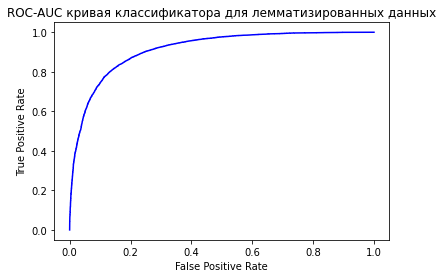

In [79]:
import matplotlib.pyplot as plt

probs_lem = clf1.predict_proba(X_test_lemmatized)[:,1]
fpr, tpr, threshold = roc_curve(test_labels, probs_lem)

plt.title('ROC-AUC кривая классификатора для лемматизированных данных')
plt.plot(fpr, tpr, 'b')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Обучаем и оцениваем классификатор на нелемматизированных данных:

In [80]:
clf2 = MultinomialNB().fit(X_train_preprocessed, train_labels)
predicted_preprocessed = clf2.predict(X_test_preprocessed)

In [81]:
print('Метрики качества классификатора на нелемматизированных данных')
print(classification_report(test_labels, predicted_preprocessed))
print('Значение ROC-AUC: ', roc_auc_score(test_labels, predicted_preprocessed))

Метрики качества классификатора на нелемматизированных данных
              precision    recall  f1-score   support

           0       0.78      0.89      0.84     12500
           1       0.88      0.75      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000

Значение ROC-AUC:  0.82428


Значения метрик уменьшились всего лишь на одну сотую. Значит, лемматизация не имеет ключевую роль при оценке тональности (однако и одна сотая может в зависимости от цели может дать очень многое!). Значение ROC-AUC отличается даже меньше, чем на сотую.

Можно заметить, что на нелемматизированных данных классификатор хуже обнаруживает тексты с меткой 0 (негативные)

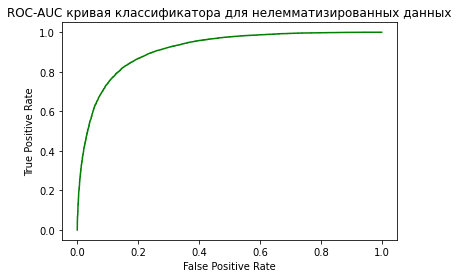

In [82]:
import matplotlib.pyplot as plt

probs_prep = clf2.predict_proba(X_test_preprocessed)[:,1]
fpr, tpr, threshold = roc_curve(test_labels, probs_prep)

plt.title('ROC-AUC кривая классификатора для нелемматизированных данных')
plt.plot(fpr, tpr, 'g')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Топ-15 рецензий

Я выведу топ-15 негативных и позитивных рецензий, основываясь на классификаторе, обученном на лемматизированных данных. 

Мы выяснили, что он немножко лучше, и в целом, скорее всего, этот топ-15 не будет значительно отличаться.

In [53]:
import numpy as np 

sort_args = np.argsort(probs_lem)
top_negative = test['text'].loc[sort_args[:15]]
top_positive = test['text'].loc[sort_args[::-1][:15]]

Топ-15 самых позитивных рецензий:

In [56]:
for text in top_positive.values:
  print(text)
  print('\n')

We all want to fall in love... The experience makes us feel completely alive, where every sense is heightened, every emotion is magnified... It may only last a moment, an hour, an afternoon, but that doesn't reduce its value, because we are left with memories that we treasure for the rest of our lives...<br /><br />I love watching people fall in love... It must have something to do with the excellent chemistry between the main characters...<br /><br />Mark Elliott, a charming sensitive American war correspondent, arrives in Hong Kong at the dawn of the Korean war... He finds in Han Suyin an awesome beauty of true grace...<br /><br />Han Suyin, a lovely Eurasian doctor is captivated by Mark's tenderness and insight...<br /><br />It was instant attraction when they first met... The two commence a passionate affair, leading them to fall deeply in love...<br /><br />Their love is so strong, so wonderfully expressed that highlights Elliot's married status, and the difficulties of the troubl

Топ-15 самых негативных рецензий:

In [57]:
for text in top_negative.values:
  print(text)
  print('\n')

This is just the same old crap that is spewed from amateur idiots who have no clue how to make a movie--gee maybe that's why it is a straight-to-video wanna-be movie!<br /><br />I guess it is my fault for actually spending money to see it (one of the worst decisions I have ever made). What a waste. I usually like B movies, some of them are actually quite good--but this is just too ridiculous and stupid to even be funny.<br /><br />The losers that made this junk deserve to be put out of business for wasting everyone's time and money making a movie that obviously doesn't even deserve to be on film! These so-called movie makers have absolutely NO talent!<br /><br />Stupid plot, horrible acting (especially the drag queens--what sicko would actually find that sexy?!), lame writing (if there even was a script--seems like the kinda bull**** someone just made up on the spot)<br /><br />What is stunning about this movie is its utter lack of anything well-done at all.<br /><br />How much attenti

Действительно, распечатанные текста подходят под соответствующий топ и очень эмоционально ярки!

# Ручной подсчет метрик

Напишем отдельно функцию, считающую tp, tn, fp, fn, и будем использовать ее внутри функций для подсчета основных метрик

In [89]:
def values_for_metrics(y_true, y_pred):
  tp = y_pred[(y_true==y_pred)&(y_pred==1)].shape[0]
  tn = y_pred[(y_true==y_pred)&(y_pred==0)].shape[0]
  fp = y_pred[(y_true!=y_pred)&(y_pred==1)].shape[0]
  fn = y_pred[(y_true!=y_pred)&(y_pred==0)].shape[0]
  return tp,tn,fp,fn

def accuracy(y_true, y_pred):
  tp,tn,fp,fn = values_for_metrics(y_true, y_pred)
  return (tp+tn)/(tp+tn+fp+fn)

def precision(y_true, y_pred):
  tp,tn,fp,fn = values_for_metrics(y_true, y_pred)
  return tp/(tp+fp)

def recall(y_true, y_pred):
  tp,tn,fp,fn = values_for_metrics(y_true, y_pred)
  return tp/(tp+fn)

def f1(y_true, y_pred):
  pr = precision(y_true, y_pred)
  rec = recall(y_true, y_pred)
  return 2*pr*rec/(pr+rec)

Проверим, совпадают ли значения для классификатора на лемматизированных данных:

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(accuracy_score(test_labels, predicted_lemmatized) == accuracy(test_labels, predicted_lemmatized))
print(precision_score(test_labels, predicted_lemmatized) == precision(test_labels, predicted_lemmatized))
print(recall_score(test_labels, predicted_lemmatized) == recall(test_labels, predicted_lemmatized))
print(f1_score(test_labels, predicted_lemmatized) == f1(test_labels, predicted_lemmatized))

True
True
True
True


Все совпало!

А теперь, на всякий случай, для второго классификатора:

In [92]:
print(accuracy_score(test_labels, predicted_preprocessed) == accuracy(test_labels, predicted_preprocessed))
print(precision_score(test_labels, predicted_preprocessed) == precision(test_labels, predicted_preprocessed))
print(recall_score(test_labels, predicted_preprocessed) == recall(test_labels, predicted_preprocessed))
print(f1_score(test_labels, predicted_preprocessed) == f1(test_labels, predicted_preprocessed))

True
True
True
True


И тут тоже значения получились те же, что и посчитанные в sklearn.